# GenZoo generative data pipeline

## 1. Shape and pose sampling

In [1]:
from utils import deduce_randomized_weak_perspective_params, MeshRenderer, overlay_rgba_on_rgb, SMALLayer, create_pose_rotmat
from awol import ObjectNet
from diffusers import FluxControlNetModel
from diffusers.pipelines import FluxControlNetPipeline
from types import SimpleNamespace
from PIL import Image
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
import os
import random
os.environ["PYOPENGL_PLATFORM"] = "egl"  # 'osmesa' # Useful when running on a headless server

/lustre/fast/fast/ntomasz/GenZoo-repo/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 1
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"  # required by torch.use_deterministic_algorithms
torch.use_deterministic_algorithms(True, warn_only=False)

random.seed(SEED)
np.random.seed(SEED)
g = torch.Generator(device="cuda").manual_seed(SEED)

torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Disable fast-but-nondeterministic attention kernels
torch.backends.cuda.enable_flash_sdp(False)
torch.backends.cuda.enable_mem_efficient_sdp(False)
torch.backends.cuda.enable_math_sdp(True)

# Avoid TF32 variability
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False

In [3]:
smal = SMALLayer(model_path="./data/smal_plus.pkl", num_betas=SMALLayer.SHAPE_SPACE_DIM)
attributes = dict(np.load("./data/animal_attributes.npz"))
poses = dict(np.load("./data/dog_poses.npz"))

In [4]:
opts = SimpleNamespace()
opts.model_type = "flow"
opts.flow_type = "realnvp"
opts.object = "animal"
opts.train_mask = True
opts.num_hidden = 1024
opts.num_blocks = 5
opts.animal_emb_dim = 145
opts.noise = True
opts.add_mask_cond = False
opts.no_compression = False

In [5]:
def sample_shape(model, attributes, animal, max_attempts=10, rng=None):
    """Generate valid betas for the given animal."""
    animal_mask = attributes["animals"] == animal
    if not np.any(animal_mask):
        allowed = ", ".join(sorted(set(attributes["animals"])))
        raise ValueError(
            f"Unknown animal '{animal}'. Allowed names are: {allowed}"
        )
    if rng is None:
        rng = np.random.default_rng()

    mean = attributes["mean"][animal_mask][0]
    cov = attributes["cov"][animal_mask][0]
    
    for _ in range(max_attempts):
        features = torch.tensor(rng.multivariate_normal(mean, cov, 1))
        features /= features.norm(dim=-1, keepdim=True)
        
        betas = model(features.float(), predict=True, sigma=3).cpu().numpy().squeeze()
        
        if np.all(np.abs(betas) <= 10):
            return betas
    
    return betas  # fallback

In [6]:
animal_name = "Border Collie"

awol = ObjectNet(opts)
awol.load_state_dict(torch.load("./data/submission_animal_realnvp_mask_pred_net_6000.pth", weights_only=True))
awol.eval()

with torch.inference_mode():
    shape = sample_shape(awol, attributes, animal_name.title(), rng=np.random.default_rng(42))

rng = np.random.default_rng(SEED)
pose = poses["pose_6d"][rng.integers(poses["pose_6d"].shape[0])]
orient = poses["orient_6d"][rng.integers(poses["orient_6d"].shape[0])]

pose = create_pose_rotmat(pose, orient)

global_orient, body_pose = pose[0][None], pose[1:][None]

smal_output = smal(
        betas=torch.tensor(shape[None]),
        body_pose=torch.tensor(body_pose),
        global_orient=torch.tensor(global_orient),
)
    
verts = smal_output.vertices[0].cpu().numpy()

## 2. Rendering the control signal

In [7]:
s, tx, ty = np.array(deduce_randomized_weak_perspective_params(verts)) / 1024
s *= 2
tx = (tx-0.5)*2
ty = (ty-0.5)*2
camera = np.array([s, s, tx/s, ty/s])
LIGHT_BLUE = (0.65098039, 0.74117647, 0.85882353)
renderer = MeshRenderer(smal.faces, resolution=(1024, 1024))

In [8]:
rgb = renderer.render(verts, camera, color=None)
depth = renderer.render(verts, camera, depth_only=True)

depth[depth == 0] = np.nan
depth = 1 - (depth - np.nanmin(depth)) / (np.nanmax(depth) - np.nanmin(depth))
depth[np.isnan(depth)] = 0
depth = np.rint(depth * 255).astype(np.uint8)
# Restart the cell if the renderer crashes

### Canny Edge

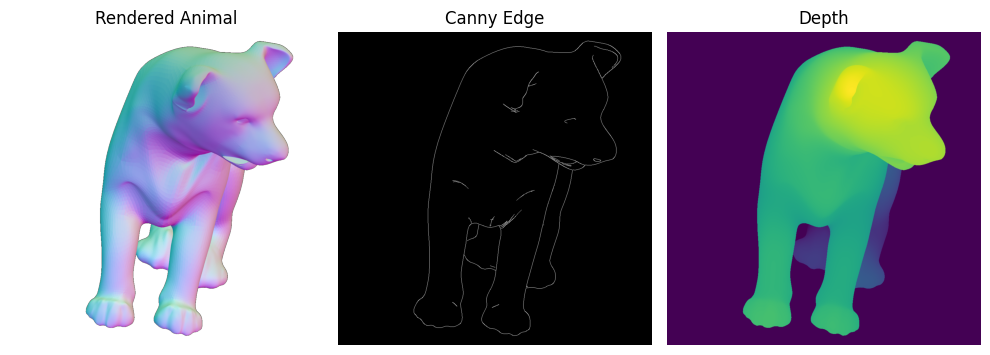

In [9]:
canny = cv2.Canny(np.array(rgb), 100, 200)[:, :, None].repeat(3, axis=2)

images = [rgb, Image.fromarray(canny), Image.fromarray(depth)]
titles = ["Rendered Animal", "Canny Edge", "Depth"]

fig, axes = plt.subplots(1, len(images), figsize=(10, 5))
for ax, img, title in zip(axes, images, titles):
    ax.imshow(img)
    ax.set_title(title)
    ax.axis("off")

plt.tight_layout()
plt.show()

## 3. Prompting

In [10]:
prompt = "A Border Collie photographed with a telephoto lens from a distance standing on uneven forest terrain, surrounded by trees and foliage. The dog has a black-and-white coat with a thick, slightly wavy fur and a white blaze running down its face. Leaning forward with all four legs visible, looking to its left at something on the ground."

## 4. Image Generation

In [11]:
controlnet_canny = FluxControlNetModel.from_pretrained(
  "Xlabs-AI/flux-controlnet-canny-diffusers",
  torch_dtype=torch.bfloat16,
  use_safetensors=True,
)
controlnet_depth = FluxControlNetModel.from_pretrained(
  "Xlabs-AI/flux-controlnet-depth-diffusers",
  torch_dtype=torch.bfloat16,
  use_safetensors=True,
)
pipe = FluxControlNetPipeline.from_pretrained(
  "black-forest-labs/FLUX.1-dev",
  controlnet=[controlnet_canny, controlnet_depth],
  torch_dtype=torch.bfloat16,
)
pipe = pipe.to("cuda")

/lustre/fast/fast/ntomasz/GenZoo-repo/.venv/lib/python3.11/site-packages/diffusers/models/embeddings.py:2609: FutureWarning: `FluxPosEmbed` is deprecated and will be removed in version 1.0.0. Importing and using `FluxPosEmbed` from `diffusers.models.embeddings` is deprecated. Please import it from `diffusers.models.transformers.transformer_flux`.
  deprecate("FluxPosEmbed", "1.0.0", deprecation_message)
Loading pipeline components...:  14%|█████                              | 1/7 [00:00<00:02,  2.11it/s]`torch_dtype` is deprecated! Use `dtype` instead!

Loading pipeline components...: 100%|███████████████████████████████████| 7/7 [00:03<00:00,  1.85it/s]


In [12]:
generator = torch.manual_seed(SEED)

image = pipe(
    prompt,
    control_image=[Image.fromarray(canny), Image.fromarray(depth).convert("RGB")],
    controlnet_conditioning_scale=[0.2, 0.65],
    num_inference_steps=28,
    guidance_scale=3.5,
    height=1024,
    width=1024,
    num_images_per_prompt=1,
    generator=generator
).images[0]

100%|█████████████████████████████████████████████████████████████████| 28/28 [00:31<00:00,  1.13s/it]


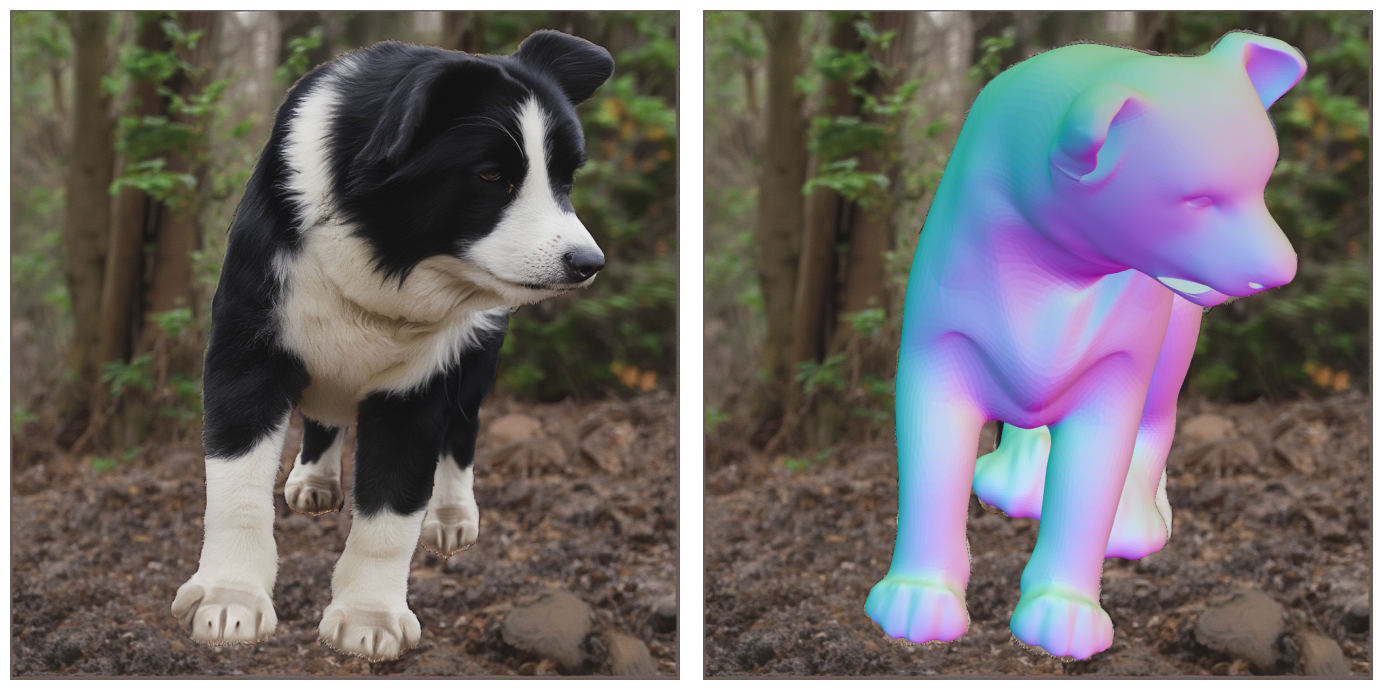

In [16]:
overlay = overlay_rgba_on_rgb(rgb, np.array(image))
plt.figure(figsize=(14,7)); 
plt.subplot(1,2,1); plt.imshow(image); plt.axis("off"); 
plt.subplot(1,2,2); plt.imshow(overlay); plt.axis("off"); 
plt.tight_layout(); plt.show()